# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: Linear GAN with MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [3]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need the labels here
data = data[:,1:]

# normalize the data to a range of [-1 1] (b/c tanh output)
dataNorm = data / np.max(data)
dataNorm = 2*dataNorm - 1

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# no dataloaders!
batchsize = 100

# Create classes for the discriminator and generator

In [4]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4292],
        [0.4784],
        [0.4724],
        [0.4697],
        [0.4555],
        [0.4660],
        [0.4687],
        [0.4807],
        [0.4525],
        [0.4718]], grad_fn=<SigmoidBackward0>)

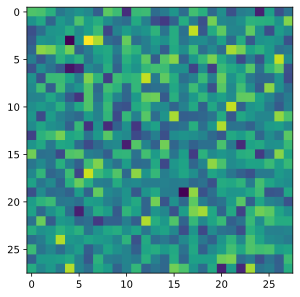

In [5]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models!

In [6]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [7]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 50000

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):

  # create minibatches of REAL and FAKE images
  randidx     = torch.randint(dataT.shape[0],(batchsize,))
  real_images = dataT[randidx,:].to(device)
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator


  # labels used for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(real_images)              # REAL images into discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  pred_fake   = dnet(fake_images)              # FAKE images into discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()




  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)

  # compute and collect loss and accuracy
  g_loss = lossfun(pred_fake,real_labels)
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  # print out a status message
  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)


Finished epoch 50000/50000

In [8]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Let's see some fake digits!

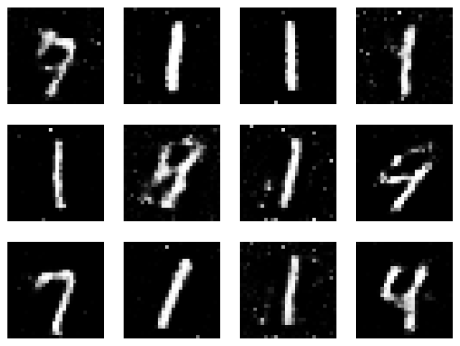

In [9]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

# Additional explorations

In [10]:
# 1) I tried adding batch normalization to the models, but the results weren't that nice. Can you guess why? Try adding
#    batchnorm after each layer (except the output) and observe the effects. Can you explain why the results are the
#    way they are? (Note: batchnorm becomes important in deeper CNN GANs.)
#
# 2) Re-running the same code to show the fake images returns different digits each time. Fix PyTorch's random seed so
#    that the random numbers are identical each time you run the code. Are the images still different on multiple runs?
#
# 3) To see how the generator is progressing, you can create some images during training. Here's what to do: (1) put the
#    image-generation code above inside a function. (2) Modify that function so that the figure is saved to a file.
#    (3) Modify the training function so that it calls the plotting function every 5000 epochs (or whatever resolution
#    you want). Then you can see how the images look more like digits as the generator model learns!
#
# 4) GANs can be quite sensitive to the learning rate, because you are training two different but interacting networks
#    at the same time. Usually a good strategy is to have a very small learning rate and train for a long time. But don't
#    take my advice -- try a much larger learning rate for a shorter period of time, and see what happens!
#